This is an implementation for LSTM using PyTorch

In [6]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib
# matplotlib.use('Agg')
%matplotlib inline

import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np

import utility as util

global logger

util.setup_log()
# util.setup_path()
logger = util.logger


In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, logger):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.logger = logger
        
    def forward(self, input_data):
        #Set initial states
        h0 = torch.zeros(self.num_layers, input_data.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, input_data.size(0), self.hidden_size)
        
        #Forward propagation of RNN
        self.logger.info("input_data: %s", input_data)
        out, self.hidden = self.lstm(input_data, (h0, c0))
        
        #Decode hidden state of last time step, and followed by a fully connected layer
#         logger.info("Shape of out: %s", out.shape)
        self.logger.info("out: %s", out[:, -1, :])
        out = self.fc(out[:, -1, :])
#         logger.info("Shape of final out: %s", out.shape)
#         print(out)
        return out

    def init_hidden(self):
        return (torch.zeros(self.num_layers, -1, self.hidden_size),
                torch.zeros(self.num_layers, -1, self.hidden_size))

In [83]:
# Train the model
class LSTM_model:
    def __init__(self, file_data, logger, hidden_size = 64, num_layers = 1, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = True):
    
        dat = pd.read_csv(file_data, nrows = 1000 if debug else 5000)
        dat = dat.drop(dat.columns[0], axis=1)
        print(dat)
        self.logger = logger
        self.logger.info("Shape of data: %s.\nMissing in data: %s.", dat.shape, dat.isnull().sum().sum())

        self.X = dat.as_matrix()
        self.y = np.array(dat.pm25)

        self.T = T
        self.batch_size = batch_size

        self.lstm = LSTM(input_size=self.X.shape[1], hidden_size=hidden_size, num_layers=num_layers, logger=logger)
        self.optimizer = torch.optim.Adam(self.lstm.parameters(), lr=learning_rate)

        self.train_size = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_size]) # Question: why Adam requires data to be normalized?
        self.logger.info("Training size: %d.", self.train_size)
    
    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        logger.info("Iterations per epoch: %3.3f ~ %d.", self.train_size * 1. / self.batch_size, iter_per_epoch)
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        for i in range(n_epochs):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]

                loss = self.train_iteration(X, y_target)
                logger.info("loss: %s", loss)
                self.iter_losses[int(i * iter_per_epoch + j / self.batch_size)] = loss
                #if (j / self.batch_size) % 50 == 0:
                #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / self.batch_size, loss)
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9


            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 10 == 0:
                self.logger.info("Epoch %d, loss: %3.3f.", i, self.epoch_losses[i])

            if i % 10 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_target):
        self.optimizer.zero_grad()        
        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
#         self.lstm.hidden = self.lstm.init_hidden()
        #Cast the type DoubleTensor to FloatTensor
        y_pred = self.lstm(torch.from_numpy(X).type(torch.FloatTensor)).transpose(0,1)[0]

        y_true = torch.from_numpy(y_target).type(torch.FloatTensor)
        logger.info("y_pred: %s", y_pred)
        logger.info("y_true: %s", y_true)
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.optimizer.step()

        return loss.data[0]

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]

            y_pred[i:(i + self.batch_size)] = self.lstm(torch.from_numpy(X).type(torch.FloatTensor)).detach().numpy().transpose(0,1)[0]
            i += self.batch_size
        return y_pred
        

2018-05-07 17:37:47,652 - VOC_TOPICS - INFO - Shape of data: (1000, 21).
Missing in data: 0.
2018-05-07 17:37:47,654 - VOC_TOPICS - INFO - Training size: 700.
2018-05-07 17:37:47,656 - VOC_TOPICS - INFO - Iterations per epoch: 5.469 ~ 6.
2018-05-07 17:37:47,659 - VOC_TOPICS - INFO - input_data: tensor([[[ 1.4120e+02,  2.9755e+02,  2.8979e+02,  ...,  7.8120e-02,
          -8.2491e-02, -4.0753e-02],
         [ 1.0430e+02,  3.0431e+02,  2.8894e+02,  ..., -1.7351e-01,
          -3.8864e-03, -7.8078e-02],
         [ 6.3100e+01,  2.9896e+02,  2.8722e+02,  ..., -1.7038e-01,
          -6.2768e-03, -6.4380e-02],
         ...,
         [ 1.1480e+02,  2.9718e+02,  2.9229e+02,  ..., -7.7527e-02,
          -1.2345e-02, -9.1961e-02],
         [ 2.3560e+02,  2.9550e+02,  2.9126e+02,  ..., -7.9641e-02,
          -8.6353e-02, -8.5617e-02],
         [ 2.3600e+01,  2.9575e+02,  2.9103e+02,  ...,  1.3539e-03,
          -1.7240e-01, -1.0180e-01]],

        [[ 6.7000e+01,  2.7170e+02,  2.5704e+02,  ..., -4.

2018-05-07 17:37:47,723 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:47,727 - VOC_TOPICS - INFO - y_pred: tensor([ 9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,  9.6668,
         9.6668,  9.6668,  9.6668, 

2018-05-07 17:37:47,774 - VOC_TOPICS - INFO - y_true: tensor([ -82.7106,  -18.2106,  -20.7106,   59.2894,  -30.7106,  -92.7106,
         -54.1106,  -22.8106,   11.2894,  -15.7106,  -84.7106,  -89.7106,
         497.2894,   94.2894,  -85.7106,  -30.7106,  -84.7106,  -10.6106,
         146.2894,   45.4894,   36.1894,   47.4894,  -70.7106,  145.2894,
         -35.3106,   -6.7106,  -17.7106,  -60.7106,   20.2894,   74.2894,
          34.2894,   48.2894,  -16.7106,   -1.7106,  -70.1106,  -83.6106,
         -24.9106,  119.0894,  -67.0106,  139.8894,  -73.1106,   75.6894,
         -86.0106,   90.2894,  -20.8106,  -30.7106,  -59.7106,  -85.7106,
         -23.7106,  -50.7106,  -69.7106,   15.2894,  -51.7106,  -39.5106,
         116.2894,   17.2894,   81.2894,  -30.7106,   58.2894,    2.9894,
         -30.3106,   37.2894,  -85.7106,    0.5894,  -13.3106,   -4.7106,
          94.2894,   85.2894,  -35.7106,  266.2894,  -29.2106,  -27.9106,
         -71.2106,  -80.7106,   71.2894,  -78.5106,  -32.6

2018-05-07 17:37:47,844 - VOC_TOPICS - INFO - loss: tensor(8442.2705)
2018-05-07 17:37:47,847 - VOC_TOPICS - INFO - input_data: tensor([[[ 2.1480e+02,  3.0304e+02,  2.9613e+02,  ..., -2.5119e-01,
          -2.8144e-01, -1.2671e-01],
         [ 1.9470e+02,  2.9845e+02,  2.9595e+02,  ...,  2.9854e-02,
           6.7455e-02, -1.7677e-02],
         [ 1.7140e+02,  2.9637e+02,  2.9447e+02,  ...,  5.0907e-02,
           2.5533e-02, -5.4359e-02],
         ...,
         [ 2.4480e+02,  2.9707e+02,  2.9407e+02,  ..., -9.2972e-02,
          -2.3836e-02, -9.2880e-02],
         [ 2.5150e+02,  2.9855e+02,  2.9449e+02,  ...,  7.9732e-03,
          -4.2407e-02, -7.7435e-02],
         [ 2.2210e+02,  3.0493e+02,  2.9367e+02,  ...,  2.9118e-02,
          -2.7882e-02, -1.0299e-01]],

        [[ 6.4500e+01,  2.9757e+02,  2.9045e+02,  ..., -1.8412e-02,
          -1.7305e-01, -8.1664e-02],
         [ 1.2360e+02,  2.9885e+02,  2.9185e+02,  ...,  2.2407e-02,
          -1.7838e-01, -8.4882e-02],
         [ 1.481

      pm25         t2m         d2m       u10       v10            sp  \
0     51.0  270.487368  258.980250  2.507680 -0.658156  97997.728951   
1     23.0  283.838611  258.241520  3.154037 -0.050984  98048.881796   
2     66.0  273.009328  261.723400  1.842218 -1.248453  98354.616140   
3    127.0  270.101179  262.794066  0.369782 -1.550008  98568.984998   
4    119.0  268.554291  262.665035  0.382165 -1.082520  98565.141143   
5    108.0  281.021141  262.805886  1.372043  0.864305  98220.376883   
6    168.0  274.254307  263.928755  1.946937 -1.228454  98300.802165   
7    122.0  273.074404  262.622681  1.463319 -2.884348  98494.769021   
8     30.0  270.140652  260.127744  0.696676 -2.797163  98825.044903   
9     16.0  280.057803  259.841117  0.031922 -1.408137  98795.476785   
10    57.0  272.718087  261.033919  0.904699  2.489575  99022.559934   
11    76.0  268.415605  263.193965  0.498912  2.338641  99041.483529   
12    78.0  266.483595  263.732746 -0.057585  2.579573  98944.20

2018-05-07 17:37:47,866 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:47,870 - VOC_TOPICS - INFO - y_pred: tensor([ 6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,  6.7151,
         6.7151,  6.7151,  6.7151, 

2018-05-07 17:37:47,900 - VOC_TOPICS - INFO - y_true: tensor([ -15.7106,  -26.7106,  -83.8106,  -26.8106,  -72.5106,  -52.6106,
         -84.7106,   43.3894,  -13.7106,  103.0894,    8.5894,  -20.0106,
           6.2894,   17.2894,  127.0894,  127.7894,   29.2894,  -71.1106,
         -77.6106,   29.2894,  -66.9106,  -81.7106,   10.2894,  -51.0106,
         -73.7106,  -20.4106,   -6.2106,   15.4894,   86.6894,  -65.1106,
         -35.2106,  -77.2106,  127.2894,   -5.7106,  -18.9106,  -57.7106,
         -28.7106,  -20.8106,   11.9894,  -76.0106,  -74.7106,  168.2894,
         -51.7106,  -84.7106,  -63.5106,  -77.8106,  105.2894,  -19.7106,
         -85.7106,   30.2894])
2018-05-07 17:37:47,907 - VOC_TOPICS - INFO - loss: tensor(4432.2764)
2018-05-07 17:37:47,909 - VOC_TOPICS - INFO - Epoch 0, loss: 7634.193.
2018-05-07 17:37:47,914 - VOC_TOPICS - INFO - input_data: tensor([[[ 5.1000e+01,  2.7049e+02,  2.5898e+02,  ..., -3.6216e-01,
           2.7026e-01,  2.5739e-01],
         [ 2.3000e+

2018-05-07 17:37:47,947 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:47,958 - VOC_TOPICS - INFO - input_data: tensor([[[ 1.2400e+02,  2.7132e+02,  2.6182e+02,  ..., -1.6422e-01,
          -1.1522e-01, -3.8546e-02],
         [ 1.3400e+02,  2.7136e+02,  2.6680e+02,  ..., -1.3370e-01,
           5.2838e-02,  1.8136e-03],
         [ 1.6100e+02,  2.8263e+02,  2.6492e+02,  ...,  1.6592e-01,
           2.2301e-01,  5.2102e-02],
         ...,
         [ 1.5300e+02,  2.8278e+02,  2.5990e+02,  ...,  2.4103e-01,
          -2.1397e-03, -1.6578e-01],
         [ 9.4000e+01, 

2018-05-07 17:37:47,993 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:48,000 - VOC_TOPICS - INFO - input_data: tensor([[[ 1.5700e+02,  2.9389e+02,  2.8618e+02,  ...,  1.2142e-01,
          -9.1041e-02, -6.0243e-02],
         [ 2.5850e+02,  2.9732e+02,  2.8551e+02,  ...,  3.3347e-02,
          -1.1311e-01, -4.8935e-02],
         [ 6.7000e+01,  3.0753e+02,  2.7985e+02,  ...,  1.6141e-01,
          -3.1651e-02, -2.0210e-01],
         ...,
         [ 5.2200e+01,  3.0592e+02,  2.8029e+02,  ..., -1.3784e-01,
           1.1296e-01, -2.3584e-01],
         [ 5.2000e+01, 

2018-05-07 17:37:48,035 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:48,043 - VOC_TOPICS - INFO - input_data: tensor([[[ 2.5150e+02,  2.9855e+02,  2.9449e+02,  ...,  7.9732e-03,
          -4.2407e-02, -7.7435e-02],
         [ 2.2210e+02,  3.0493e+02,  2.9367e+02,  ...,  2.9118e-02,
          -2.7882e-02, -1.0299e-01],
         [ 2.1350e+02,  3.0187e+02,  2.9410e+02,  ...,  3.4451e-02,
           6.7547e-02, -1.4988e-01],
         ...,
         [ 2.2280e+02,  3.0206e+02,  2.9428e+02,  ...,  1.9189e-02,
          -3.6740e-01, -2.5993e-03],
         [ 2.5720e+02, 

2018-05-07 17:37:48,087 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:48,092 - VOC_TOPICS - INFO - input_data: tensor([[[ 4.7300e+01,  3.0138e+02,  2.8254e+02,  ...,  3.4634e-02,
          -2.0863e-01, -1.7378e-01],
         [ 5.0100e+01,  2.9453e+02,  2.8447e+02,  ..., -3.6615e-02,
           4.7965e-02, -1.3830e-01],
         [ 5.4100e+01,  2.9141e+02,  2.8540e+02,  ..., -1.0690e-02,
          -8.2675e-02, -5.8404e-02],
         ...,
         [ 6.2600e+01,  2.9204e+02,  2.8640e+02,  ...,  8.4923e-02,
          -1.0042e-01, -1.1642e-01],
         [ 9.3400e+01, 

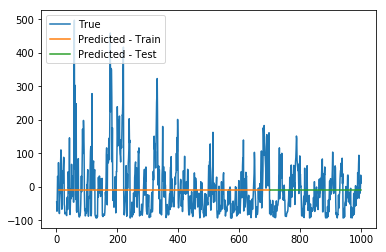

2018-05-07 17:37:48,282 - VOC_TOPICS - INFO - input_data: tensor([[[ 2.5150e+02,  2.9855e+02,  2.9449e+02,  ...,  7.9732e-03,
          -4.2407e-02, -7.7435e-02],
         [ 2.2210e+02,  3.0493e+02,  2.9367e+02,  ...,  2.9118e-02,
          -2.7882e-02, -1.0299e-01],
         [ 2.1350e+02,  3.0187e+02,  2.9410e+02,  ...,  3.4451e-02,
           6.7547e-02, -1.4988e-01],
         ...,
         [ 2.2280e+02,  3.0206e+02,  2.9428e+02,  ...,  1.9189e-02,
          -3.6740e-01, -2.5993e-03],
         [ 2.5720e+02,  2.9814e+02,  2.9605e+02,  ...,  3.6473e-02,
          -2.3744e-02, -1.9883e-02],
         [ 1.5610e+02,  2.9907e+02,  2.9645e+02,  ...,  4.7138e-02,
          -1.0414e-02,  1.4937e-01]],

        [[ 2.2210e+02,  3.0493e+02,  2.9367e+02,  ...,  2.9118e-02,
          -2.7882e-02, -1.0299e-01],
         [ 2.1350e+02,  3.0187e+02,  2.9410e+02,  ...,  3.4451e-02,
           6.7547e-02, -1.4988e-01],
         [ 1.4590e+02,  2.9773e+02,  2.9439e+02,  ..., -6.5207e-02,
          -9.9591e

2018-05-07 17:37:48,314 - VOC_TOPICS - INFO - out: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]])
2018-05-07 17:37:48,318 - VOC_TOPICS - INFO - input_data: tensor([[[ 4.7300e+01,  3.0138e+02,  2.8254e+02,  ...,  3.4634e-02,
          -2.0863e-01, -1.7378e-01],
         [ 5.0100e+01,  2.9453e+02,  2.8447e+02,  ..., -3.6615e-02,
           4.7965e-02, -1.3830e-01],
         [ 5.4100e+01,  2.9141e+02,  2.8540e+02,  ..., -1.0690e-02,
          -8.2675e-02, -5.8404e-02],
         ...,
         [ 6.2600e+01,  2.9204e+02,  2.8640e+02,  ...,  8.4923e-02,
          -1.0042e-01, -1.1642e-01],
         [ 9.3400e+01, 

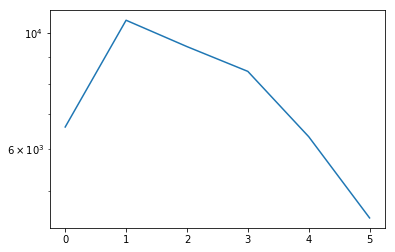

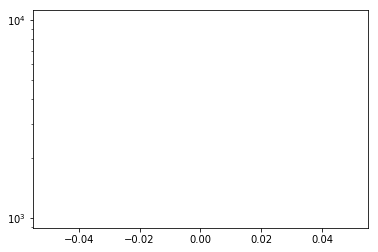

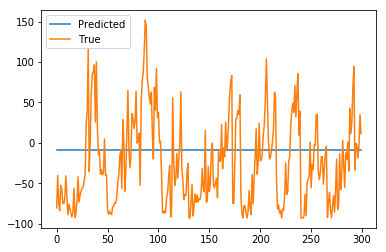

In [85]:
io_dir = '.'

model = LSTM_model(file_data = '{}/raw_data_new.csv'.format(io_dir), logger = logger, parallel = False,
              learning_rate = .5, debug=True)

model.train(n_epochs = 1)

y_pred = model.predict()

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

In [19]:
torch.randn(5, 7).type()

'torch.FloatTensor'

In [43]:
torch.tensor([[1],[2]]).transpose(0,1)[0]

tensor([ 1,  2])

In [63]:
y_pred

array([-3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07857776,
       -3.07857776, -3.07857776, -3.07857776, -3.07857776, -3.07